In [ ]:
import praw
import pandas as pd
import time
from tqdm import tqdm

# Step 1: Connect to Reddit (FULL authentication)
reddit = praw.Reddit(
    client_id="Wk871aOAVkUE3UGgS3VkIg",   
    client_secret="hJLUtQB...OI-w",  
    user_agent="HettiesSmartCityApp:v1.0 (by /u/Able-Pirate9490)",
    username="Able-Pirate9490",
    password="SmJqX!n3&?&mgac"
)

# Step 2: Define target subreddits
cities = {
    "singapore": "singapore",
    "amsterdam": "amsterdam",
    "barcelona": "barcelona"
}
keyword = "smartcity"

# Step 3: Mining Function
def mine_city_posts(subreddit_name, keyword, limit=100):
    subreddit = reddit.subreddit(subreddit_name)
    posts = subreddit.hot(limit=limit)  

    data = {
        "Title": [],
        "Text": [],
        "Score": [],
        "Comments": [],
        "Date": []
    }

    print(f"🔍 Mining posts from r/{subreddit_name}...")
    for post in tqdm(posts, total=limit, desc=f"Collecting {subreddit_name} posts"):
        #  Manually filter posts mentioning the keyword
        if keyword.lower() in post.title.lower() or keyword.lower() in post.selftext.lower():
            data["Title"].append(post.title)
            data["Text"].append(post.selftext)
            data["Score"].append(post.score)
            data["Comments"].append(post.num_comments)
            data["Date"].append(pd.to_datetime(post.created_utc, unit='s'))
        
    return pd.DataFrame(data)

# Step 4: Loop through cities and save
for city, subreddit_name in cities.items():
    df = mine_city_posts(subreddit_name, keyword, limit=100)
    csv_filename = f"{city}_smartcity_posts.csv"
    df.to_csv(csv_filename, index=False)
    print(f"✅ Saved {len(df)} posts to {csv_filename}!\n")
    
    time.sleep(5)

print("🎯 All cities scraped and saved successfully!")


In [3]:
pip install feedparser

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/81.3 kB ? eta -:--:--
   ----- ---------------------------------- 10.2/81.3 kB ? eta -:--:--
   --------------- ------------------------ 30.7/81.3 kB 660.6 kB/s eta 0:00:01
   ----------------------------------- ---- 71.7/81.3 kB 653.6 kB/s eta 0:00:01
   ---------------------------------------- 81.3/81.3 kB 652.3 kB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6060 sha256=e36e7ddfb0eb98c7cc3317d289ce18601e834a761dec27ed9993d69178e4bf78
  Stored in directory: c:\users\pc\appdata\local\pip\cache\wheels\03\f5\1a\23761066dac1d0e8e683e5fdb27e12de53209d05a4a37e6246
Successfully built sgmllib3k
Note: you may need to restart the kernel to use updated packages.


In [13]:
import feedparser
import pandas as pd
import time
from tqdm import tqdm
import re

# Step 1: Expanded target subreddits
city_subreddits = {
    "singapore": ["singapore", "askSingapore", "SGTech", "urbanplanning", "technology"],
    "amsterdam": ["amsterdam", "Netherlands", "urbanplanning", "technology"],
    "barcelona": ["barcelona", "catalunya", "spain", "urbanplanning", "technology"]
}

# Step 2: Expanded keyword list (even broader now)
keywords = [
    "smart city", "smart cities", "urban planning", "city technology", 
    "smart nation", "urban sensors", "city innovation", "digital city",
    "urban tech", "city data", "public wifi", "smart transit", 
    "smart transportation", "city apps", "traffic management",
    "public transport", "metro", "subway", "bike sharing",
    "city development", "urban mobility", "urban services",
    "city services", "parking", "surveillance", "e-government",
    "digital services", "sustainability", "infrastructure", 
    "green city", "climate smart", "city council"
]

# Step 3: Mining Function (Enhanced)
def mine_city_posts_rss(subreddit_name, keywords, loose_match=True):
    feed_types = ["", "/hot", "/new", "/top"]
    all_entries = []
    
    print(f"🔍 Mining posts from r/{subreddit_name}...")
    
    for feed_type in feed_types:
        url = f"https://www.reddit.com/r/{subreddit_name}{feed_type}/.rss"
        try:
            feed = feedparser.parse(url)
            all_entries.extend(feed.entries)
            print(f"  - Got {len(feed.entries)} entries from {feed_type if feed_type else 'default'} feed")
        except Exception as e:
            print(f"  - Error with {feed_type} feed: {e}")
    
    # Remove duplicates by ID
    unique_entries = {entry.id: entry for entry in all_entries}.values()
    
    data = {
        "Subreddit": [],
        "Title": [],
        "Text": [],
        "Keyword": [],  # Track which keyword matched (or "None" if loose match)
        "Date": [],
        "Link": []
    }
    
    for entry in tqdm(unique_entries, desc=f"Analyzing {subreddit_name} posts"):
        title = entry.title
        text = re.sub(r'<.*?>', '', entry.description)  # Remove HTML tags
        
        matched = False
        for keyword in keywords:
            if keyword.lower() in title.lower() or keyword.lower() in text.lower():
                matched = keyword
                break
        
        if matched or loose_match:
            data["Subreddit"].append(subreddit_name)
            data["Title"].append(title)
            data["Text"].append(text)
            data["Keyword"].append(matched if matched else "No Keyword Matched")
            data["Date"].append(pd.to_datetime(entry.published))
            data["Link"].append(entry.link)
    
    return pd.DataFrame(data)

# Step 4: Loop through cities
all_city_data = []

for city, subreddits in city_subreddits.items():
    city_df = pd.DataFrame()
    
    for subreddit in subreddits:
        df = mine_city_posts_rss(subreddit, keywords)
        if not df.empty:
            city_df = pd.concat([city_df, df])
    
    if not city_df.empty:
        csv_filename = f"{city}_enhanced_smartcity_posts.csv"
        city_df.to_csv(csv_filename, index=False)
        print(f"✅ Saved {len(city_df)} posts to {csv_filename}!\n")
        
        all_city_data.append(city_df)
    else:
        print(f"⚠️ No relevant posts found for {city}\n")
    
    time.sleep(2)

# Save full combined file
if all_city_data:
    combined_df = pd.concat(all_city_data)
    combined_df.to_csv("all_enhanced_smartcity_posts.csv", index=False)
    print(f"✅ Saved {len(combined_df)} total posts to all_enhanced_smartcity_posts.csv")

print("🎯 All cities scraped and saved successfully!")


🔍 Mining posts from r/singapore...
  - Got 27 entries from default feed
  - Got 27 entries from /hot feed
  - Got 25 entries from /new feed
  - Got 25 entries from /top feed


Analyzing singapore posts: 100%|██████████| 104/104 [00:00<00:00, 390.89it/s]


🔍 Mining posts from r/askSingapore...
  - Got 25 entries from default feed
  - Got 25 entries from /hot feed
  - Got 25 entries from /new feed
  - Got 25 entries from /top feed


Analyzing askSingapore posts: 100%|██████████| 100/100 [00:00<00:00, 461.65it/s]


🔍 Mining posts from r/SGTech...
  - Got 0 entries from default feed
  - Got 0 entries from /hot feed
  - Got 0 entries from /new feed
  - Got 0 entries from /top feed


Analyzing SGTech posts: 0it [00:00, ?it/s]

🔍 Mining posts from r/urbanplanning...


  - Got 27 entries from default feed
  - Got 27 entries from /hot feed
  - Got 25 entries from /new feed
  - Got 2 entries from /top feed


Analyzing urbanplanning posts: 100%|██████████| 81/81 [00:00<00:00, 340.07it/s]


🔍 Mining posts from r/technology...
  - Got 25 entries from default feed
  - Got 25 entries from /hot feed
  - Got 25 entries from /new feed
  - Got 25 entries from /top feed


Analyzing technology posts: 100%|██████████| 100/100 [00:00<00:00, 457.64it/s]


✅ Saved 385 posts to singapore_enhanced_smartcity_posts.csv!

🔍 Mining posts from r/amsterdam...
  - Got 27 entries from default feed
  - Got 27 entries from /hot feed
  - Got 25 entries from /new feed
  - Got 5 entries from /top feed


Analyzing amsterdam posts: 100%|██████████| 84/84 [00:00<00:00, 483.00it/s]

🔍 Mining posts from r/Netherlands...


  - Got 26 entries from default feed
  - Got 26 entries from /hot feed
  - Got 25 entries from /new feed
  - Got 23 entries from /top feed


Analyzing Netherlands posts: 100%|██████████| 100/100 [00:00<00:00, 428.24it/s]


🔍 Mining posts from r/urbanplanning...
  - Got 27 entries from default feed
  - Got 27 entries from /hot feed
  - Got 25 entries from /new feed
  - Got 2 entries from /top feed


Analyzing urbanplanning posts: 100%|██████████| 81/81 [00:00<00:00, 477.72it/s]


🔍 Mining posts from r/technology...
  - Got 25 entries from default feed
  - Got 25 entries from /hot feed
  - Got 25 entries from /new feed
  - Got 25 entries from /top feed


Analyzing technology posts: 100%|██████████| 100/100 [00:00<00:00, 465.99it/s]


✅ Saved 365 posts to amsterdam_enhanced_smartcity_posts.csv!

🔍 Mining posts from r/barcelona...
  - Got 27 entries from default feed
  - Got 27 entries from /hot feed
  - Got 25 entries from /new feed
  - Got 0 entries from /top feed


Analyzing barcelona posts: 100%|██████████| 79/79 [00:00<00:00, 428.24it/s]


🔍 Mining posts from r/catalunya...
  - Got 25 entries from default feed
  - Got 25 entries from /hot feed
  - Got 25 entries from /new feed
  - Got 2 entries from /top feed


Analyzing catalunya posts: 100%|██████████| 77/77 [00:00<00:00, 571.92it/s]

🔍 Mining posts from r/spain...


  - Got 26 entries from default feed
  - Got 26 entries from /hot feed
  - Got 25 entries from /new feed
  - Got 1 entries from /top feed


Analyzing spain posts: 100%|██████████| 78/78 [00:00<00:00, 630.59it/s]

🔍 Mining posts from r/urbanplanning...


  - Got 27 entries from default feed
  - Got 27 entries from /hot feed
  - Got 25 entries from /new feed
  - Got 2 entries from /top feed


Analyzing urbanplanning posts: 100%|██████████| 81/81 [00:00<00:00, 548.61it/s]

🔍 Mining posts from r/technology...


  - Got 25 entries from default feed
  - Got 25 entries from /hot feed
  - Got 25 entries from /new feed
  - Got 25 entries from /top feed


Analyzing technology posts: 100%|██████████| 100/100 [00:00<00:00, 551.61it/s]


✅ Saved 415 posts to barcelona_enhanced_smartcity_posts.csv!

✅ Saved 1165 total posts to all_enhanced_smartcity_posts.csv
🎯 All cities scraped and saved successfully!


In [15]:
import pandas as pd

# Load the full dataset
df = pd.read_csv("all_enhanced_smartcity_posts.csv")

# Drop posts where Title or Text is empty
df = df.dropna(subset=["Title", "Text"])

# Optionally remove posts with no keyword match
df = df[df["Keyword"] != "No Keyword Matched"]

# Drop duplicates based on Link
df = df.drop_duplicates(subset=["Link"])

# Save cleaned version
df.to_csv("all_enhanced_smartcity_posts_cleaned.csv", index=False)

print(f"✅ Cleaned dataset saved! {len(df)} posts remaining.")


✅ Cleaned dataset saved! 14 posts remaining.


In [17]:
import pandas as pd

# Load the cleaned dataset
df = pd.read_csv("all_enhanced_smartcity_posts_cleaned.csv")

# Show the first few rows to check
print(df.head())

# Show the total number of posts
print(f"\n✅ Total posts loaded: {len(df)}")


       Subreddit                                              Title  \
0      singapore  ‘I will talk to my good friend Lawrence Wong’:...   
1  urbanplanning  Anyone else feel stuck between loving city pla...   
2  urbanplanning  Is there a term for the tidyness of road infra...   
3  urbanplanning  For transit routes and stops located alongside...   
4  urbanplanning  Do planners/politicians/urbanists in "primate ...   

                                                Text         Keyword  \
0        Was pretty shocked to see DPM Gan’s rall...  infrastructure   
1  I’ve been sitting on this for a while and want...  urban planning   
2  This may seem like an odd question. I live in ...  infrastructure   
3  Given that a significant deal of public transi...  infrastructure   
4  First off, let's just establish right from the...           metro   

                        Date  \
0  2025-04-27 14:37:13+00:00   
1  2025-04-27 10:20:02+00:00   
2  2025-04-26 22:43:09+00:00   
3  2025-04-2

In [19]:
# Combine Title + Text into a new field
df["FullText"] = df["Title"] + " " + df["Text"]

# Save only the FullText field into a new CSV
df[["FullText"]].to_csv("smartcity_texts_for_azure.csv", index=False)

print("✅ CSV ready for Azure upload!")


✅ CSV ready for Azure upload!


In [14]:
# Load your cleaned file
import pandas as pd

df = pd.read_csv("all_enhanced_smartcity_posts_cleaned.csv")

# Combine Title + Text
df["FullText"] = df["Title"] + " " + df["Text"]

# Save each post as one line in a .txt file
with open("smartcity_texts_for_azure.txt", "w", encoding="utf-8") as f:
    for line in df["FullText"]:
        f.write(line.strip() + "\n")

print("✅ TXT file created! Ready to upload to Azure.")


✅ TXT file created! Ready to upload to Azure.


In [22]:
import pandas as pd
import requests
import time

# STEP 1: Azure setup
endpoint = "https://henrietta.cognitiveservices.azure.com/"
subscription_key = "6nZm3WMYKX8ExzNhBiBkA0eQIrGWgY5kFXN4KUYwZy72xGUUTh3uJQQJ99BEAC5T7U2XJ3w3AAAaACOGWfH6"
sentiment_url = endpoint + "/text/analytics/v3.1/sentiment"
headers = {
    "Ocp-Apim-Subscription-Key": subscription_key,
    "Content-Type": "application/json"
}

# STEP 2: Load the large dataset
df = pd.read_csv("all_enhanced_smartcity_posts.csv")

# Combine Title + Text
df["FullText"] = df["Title"].fillna("") + " " + df["Text"].fillna("")
df = df[df["FullText"].str.strip().str.len() > 5]  # remove empty or too short
df = df.reset_index(drop=True)

print(f"✅ Posts ready for analysis: {len(df)}")

# STEP 3: Process in batches
batch_size = 10
results = []

for start in range(0, len(df), batch_size):
    end = start + batch_size
    print(f"🔄 Processing posts {start} to {min(end, len(df))}...")

    batch_df = df.iloc[start:end]

    documents = [
        {
            "id": str(i),
            "language": "en",
            "text": row["FullText"]
        }
        for i, row in batch_df.iterrows()
    ]

    if not documents:
        continue

    payload = {"documents": documents}
    response = requests.post(sentiment_url, headers=headers, json=payload)

    if response.status_code == 200:
        for doc in response.json()["documents"]:
            results.append({
                "index": int(doc["id"]),
                "Sentiment": doc["sentiment"],
                "Positive": doc["confidenceScores"]["positive"],
                "Neutral": doc["confidenceScores"]["neutral"],
                "Negative": doc["confidenceScores"]["negative"]
            })
    else:
        print(f"❌ API error for batch {start}-{end}: {response.text}")

    time.sleep(1)  # polite pause

# STEP 4: Merge and Save
results_df = pd.DataFrame(results).set_index("index")
final_df = df.join(results_df, how="left")

final_df.to_csv("all_smartcity_posts_with_sentiment.csv", index=False)
print(f"✅ Analysis complete! Saved: all_smartcity_posts_with_sentiment.csv")


✅ Posts ready for analysis: 1165
🔄 Processing posts 0 to 10...
🔄 Processing posts 10 to 20...
🔄 Processing posts 20 to 30...
🔄 Processing posts 30 to 40...
🔄 Processing posts 40 to 50...
🔄 Processing posts 50 to 60...
🔄 Processing posts 60 to 70...
🔄 Processing posts 70 to 80...
🔄 Processing posts 80 to 90...
🔄 Processing posts 90 to 100...
🔄 Processing posts 100 to 110...
🔄 Processing posts 110 to 120...
🔄 Processing posts 120 to 130...
🔄 Processing posts 130 to 140...
🔄 Processing posts 140 to 150...
🔄 Processing posts 150 to 160...
🔄 Processing posts 160 to 170...
🔄 Processing posts 170 to 180...
🔄 Processing posts 180 to 190...
🔄 Processing posts 190 to 200...
🔄 Processing posts 200 to 210...
🔄 Processing posts 210 to 220...
🔄 Processing posts 220 to 230...
🔄 Processing posts 230 to 240...
🔄 Processing posts 240 to 250...
🔄 Processing posts 250 to 260...
🔄 Processing posts 260 to 270...
🔄 Processing posts 270 to 280...
🔄 Processing posts 280 to 290...
🔄 Processing posts 290 to 300.

In [24]:
import pandas as pd

# Load the final output
df = pd.read_csv("all_smartcity_posts_with_sentiment.csv")

# Preview the first few rows
print(df.head())

# Show available columns
print(f"\n📌 Columns: {list(df.columns)}")

# Show how many rows have valid sentiment
print("\n📊 Sentiment counts:")
print(df["Sentiment"].value_counts(dropna=False))


   Subreddit                                              Title  \
0  singapore  /r/singapore random discussion and small quest...   
1  singapore   General Election 2025 Resources & Discussion Hub   
2  singapore  GE2025: 'Serious problem' if PAP needs more th...   
3  singapore  Singaporeans queue to take photo with Alexis Dang   
4  singapore                     New meme template just dropped   

                                                Text             Keyword  \
0  🌻☀️Good morning all have a great day and stay ...  No Keyword Matched   
1  Timeline of Key Events &amp; Broadcasts   Date...  No Keyword Matched   
2        &#32; submitted by &#32;  /u/Im_scrub   ...  No Keyword Matched   
3        &#32; submitted by &#32;  /u/moonlightho...  No Keyword Matched   
4        Dude got cooked immediately lmao   &#32;...  No Keyword Matched   

                        Date  \
0  2025-04-26 22:01:11+00:00   
1  2025-04-15 17:03:20+00:00   
2  2025-04-27 13:26:21+00:00   
3  2025-04-2

In [26]:
# Just open and print the first 10 lines of the file
with open("all_smartcity_posts_with_sentiment.csv", "r", encoding="utf-8") as f:
    for i in range(10):
        print(f.readline().strip())


Subreddit,Title,Text,Keyword,Date,Link,FullText,Sentiment,Positive,Neutral,Negative
singapore,"/r/singapore random discussion and small questions thread for April 27, 2025","🌻☀️Good morning all have a great day and stay strong, stay safe and stay healthy! Jiayou! Talk about your day. Anything goes, but Reddit and subreddit rules still apply. Please be polite to each other!  &#32; submitted by &#32;  /u/AutoModerator   [link] &#32; [comments]",No Keyword Matched,2025-04-26 22:01:11+00:00,https://www.reddit.com/r/singapore/comments/1k8oej1/rsingapore_random_discussion_and_small_questions/,"/r/singapore random discussion and small questions thread for April 27, 2025 🌻☀️Good morning all have a great day and stay strong, stay safe and stay healthy! Jiayou! Talk about your day. Anything goes, but Reddit and subreddit rules still apply. Please be polite to each other!  &#32; submitted by &#32;  /u/AutoModerator   [link] &#32; [comments]",positive,0.85,0.13,0.02
singapore,General Election 2025

In [31]:


df = pd.read_csv("all_smartcity_posts_with_sentiment.csv")

# Filter only rows that got sentiment
valid_df = df[df["Sentiment"].isin(["positive", "neutral", "negative"])]
print(f"✅ Valid sentiment entries: {len(valid_df)}")


✅ Valid sentiment entries: 950


In [33]:
# Summary table
sentiment_counts = valid_df["Sentiment"].value_counts(normalize=True) * 100
sentiment_counts = sentiment_counts.round(1)

print("\n🧠 Sentiment breakdown (%):")
print(sentiment_counts)



🧠 Sentiment breakdown (%):
Sentiment
neutral     63.2
negative    23.4
positive    13.5
Name: proportion, dtype: float64


In [35]:
# Group by keyword + sentiment
keyword_sentiment = valid_df.groupby(["Keyword", "Sentiment"]).size().unstack().fillna(0)

# Sort by most negative reactions
keyword_sentiment["neg_pct"] = keyword_sentiment["negative"] / keyword_sentiment.sum(axis=1)
keyword_sentiment = keyword_sentiment.sort_values("neg_pct", ascending=False)

print("\n🔥 Keywords with highest negative response:")
print(keyword_sentiment.head(5))



🔥 Keywords with highest negative response:
Sentiment           negative  neutral  positive   neg_pct
Keyword                                                  
parking                  9.0      0.0       0.0  1.000000
infrastructure           9.0      0.0       4.0  0.692308
metro                    9.0      6.0       0.0  0.600000
No Keyword Matched     195.0    585.0     115.0  0.217877
sustainability           0.0      9.0       0.0  0.000000


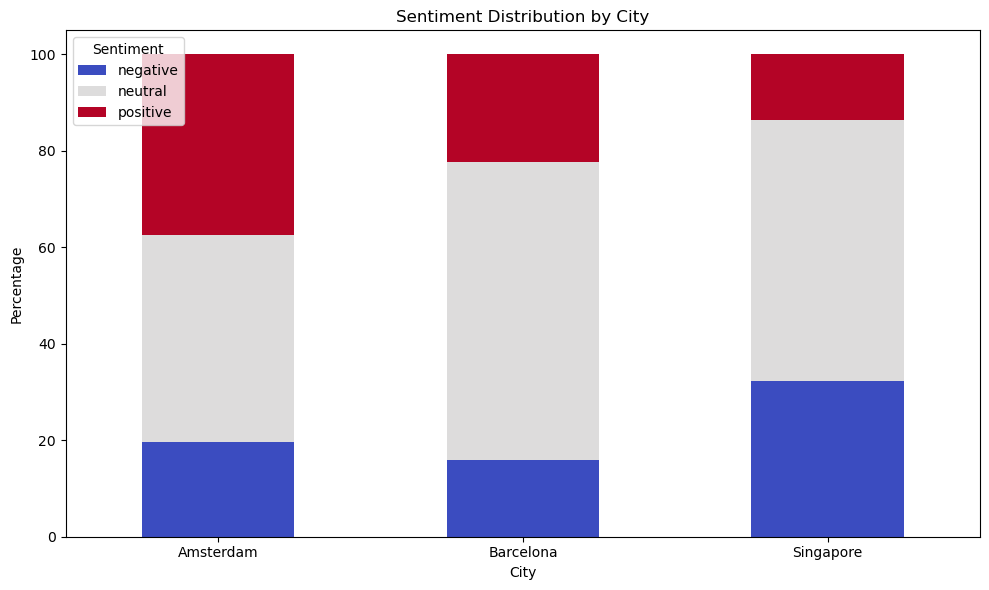

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("all_smartcity_posts_with_sentiment.csv")

# Map subreddits to cities
subreddit_to_city = {
    "singapore": "Singapore",
    "askSingapore": "Singapore",
    "SGTech": "Singapore",
    "amsterdam": "Amsterdam",
    "Netherlands": "Amsterdam",
    "barcelona": "Barcelona",
    "catalunya": "Barcelona",
    "spain": "Barcelona"
}
df["City"] = df["Subreddit"].map(subreddit_to_city)

# Keep only valid sentiment
df = df[df["Sentiment"].isin(["positive", "neutral", "negative"])]

# Group and pivot
city_group = df.groupby(["City", "Sentiment"]).size().unstack().fillna(0)
city_pct = city_group.div(city_group.sum(axis=1), axis=0) * 100

# Plot
city_pct.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="coolwarm")
plt.title("Sentiment Distribution by City")
plt.ylabel("Percentage")
plt.xlabel("City")
plt.xticks(rotation=0)
plt.legend(title="Sentiment")
plt.tight_layout()

# Save the figure
plt.savefig("Sentiment Distribution by City", dpi=300)

# Then display it
plt.show()


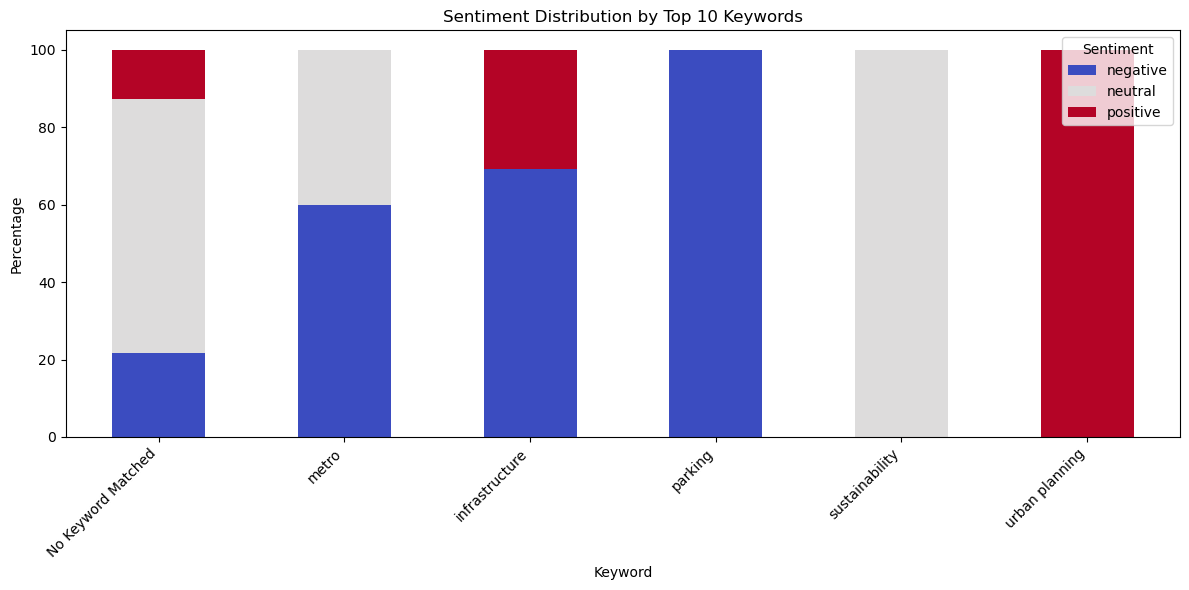

In [9]:
# Group by keyword
keyword_group = df.groupby(["Keyword", "Sentiment"]).size().unstack().fillna(0)

# Normalize and filter top 10
keyword_pct = keyword_group.div(keyword_group.sum(axis=1), axis=0) * 100
top_keywords = keyword_group.sum(axis=1).sort_values(ascending=False).head(10).index

# Plot
keyword_pct.loc[top_keywords].plot(kind="bar", stacked=True, figsize=(12, 6), colormap="coolwarm")
plt.title("Sentiment Distribution by Top 10 Keywords")
plt.ylabel("Percentage")
plt.xlabel("Keyword")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Sentiment")
plt.tight_layout()

# Save the figure
plt.savefig("Sentiment Distribution by Top 10 Keywords", dpi=300)

# Then display it
plt.show()



In [31]:
city_map = {
    "singapore": "Singapore",
    "askSingapore": "Singapore",
    "SGTech": "Singapore",
    "amsterdam": "Amsterdam",
    "Netherlands": "Amsterdam",
    "barcelona": "Barcelona",
    "catalunya": "Barcelona",
    "spain": "Barcelona",
    "urbanplanning": "General",
    "technology": "General"
}


In [33]:
df["City"] = df["Subreddit"].map(city_map).fillna("Other")


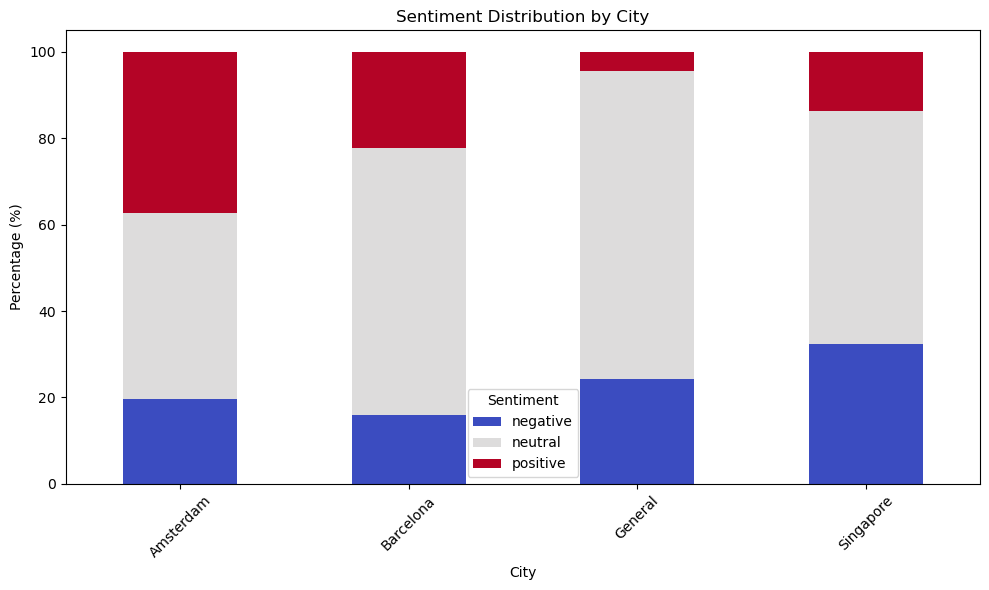

In [37]:
import matplotlib.pyplot as plt

# Reuse cleaned City mapping
df["City"] = df["Subreddit"].map(city_map).fillna("Other")

# Count and normalize sentiment per city
city_sentiment = df.groupby(["City", "Sentiment"]).size().unstack(fill_value=0)
city_sentiment_pct = city_sentiment.div(city_sentiment.sum(axis=1), axis=0) * 100

# Plot
city_sentiment_pct.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="coolwarm")
plt.title("Sentiment Distribution by City")
plt.ylabel("Percentage (%)")
plt.xlabel("City")
plt.xticks(rotation=45)
plt.legend(title="Sentiment")
plt.tight_layout()
plt.savefig("sentiment_by_city.png", dpi=300)
plt.show()


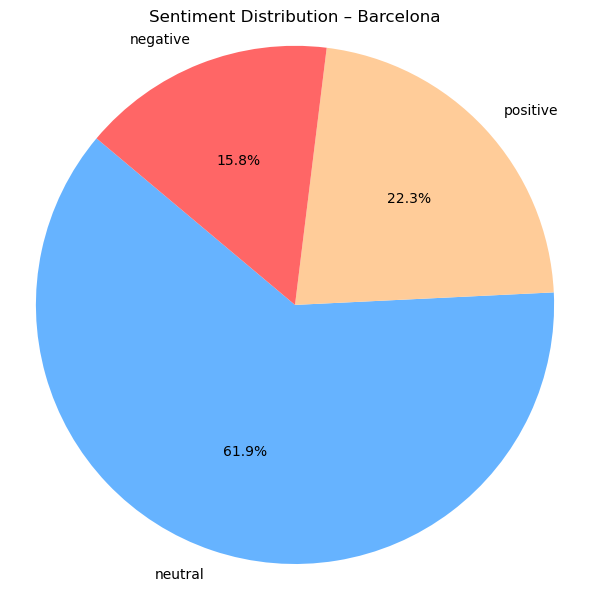

In [39]:
# Reuse city mapping
df["City"] = df["Subreddit"].map(city_map).fillna("Other")

# Filter for a city
city_name = "Barcelona"
barcelona_df = df[df["City"] == city_name]

# Count sentiment for that city
city_sentiment = barcelona_df["Sentiment"].value_counts()
labels = city_sentiment.index
sizes = city_sentiment.values

# Plot
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['#66b3ff', '#ffcc99', '#ff6666'], startangle=140)
plt.title(f"Sentiment Distribution – {city_name}")
plt.axis('equal')
plt.tight_layout()
plt.savefig(f"{city_name.lower()}_sentiment_pie.png", dpi=300)
plt.show()


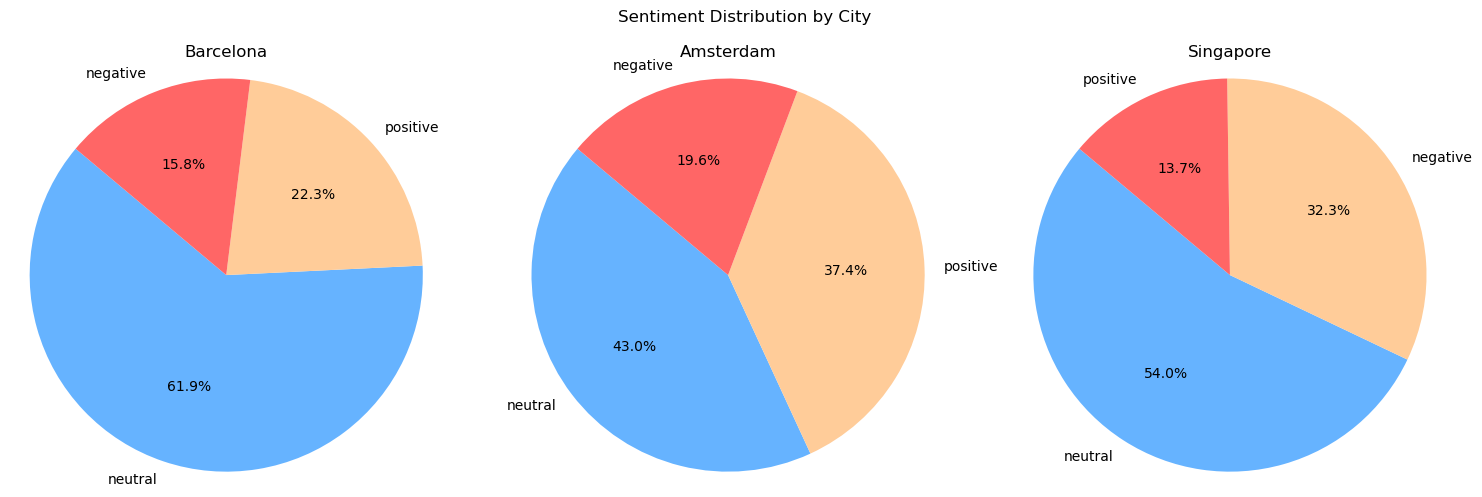

In [55]:
import matplotlib.pyplot as plt

# Ensure 'City' column is present
df["City"] = df["Subreddit"].map(city_map).fillna("Other")

# Define target cities
target_cities = ["Barcelona", "Amsterdam", "Singapore"]
colors = ['#66b3ff', '#ffcc99', '#ff6666']  # positive, neutral, negative

# Set up subplot grid
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, city in enumerate(target_cities):
    city_df = df[df["City"] == city]
    sentiment_counts = city_df["Sentiment"].value_counts()
    labels = sentiment_counts.index
    sizes = sentiment_counts.values

    axes[i].pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
    axes[i].axis('equal')
    axes[i].set_title(f"{city}")

# Overall layout
plt.suptitle("Sentiment Distribution by City")
plt.tight_layout()
plt.savefig("sentiment_pies_by_city.png", dpi=300)
plt.show()


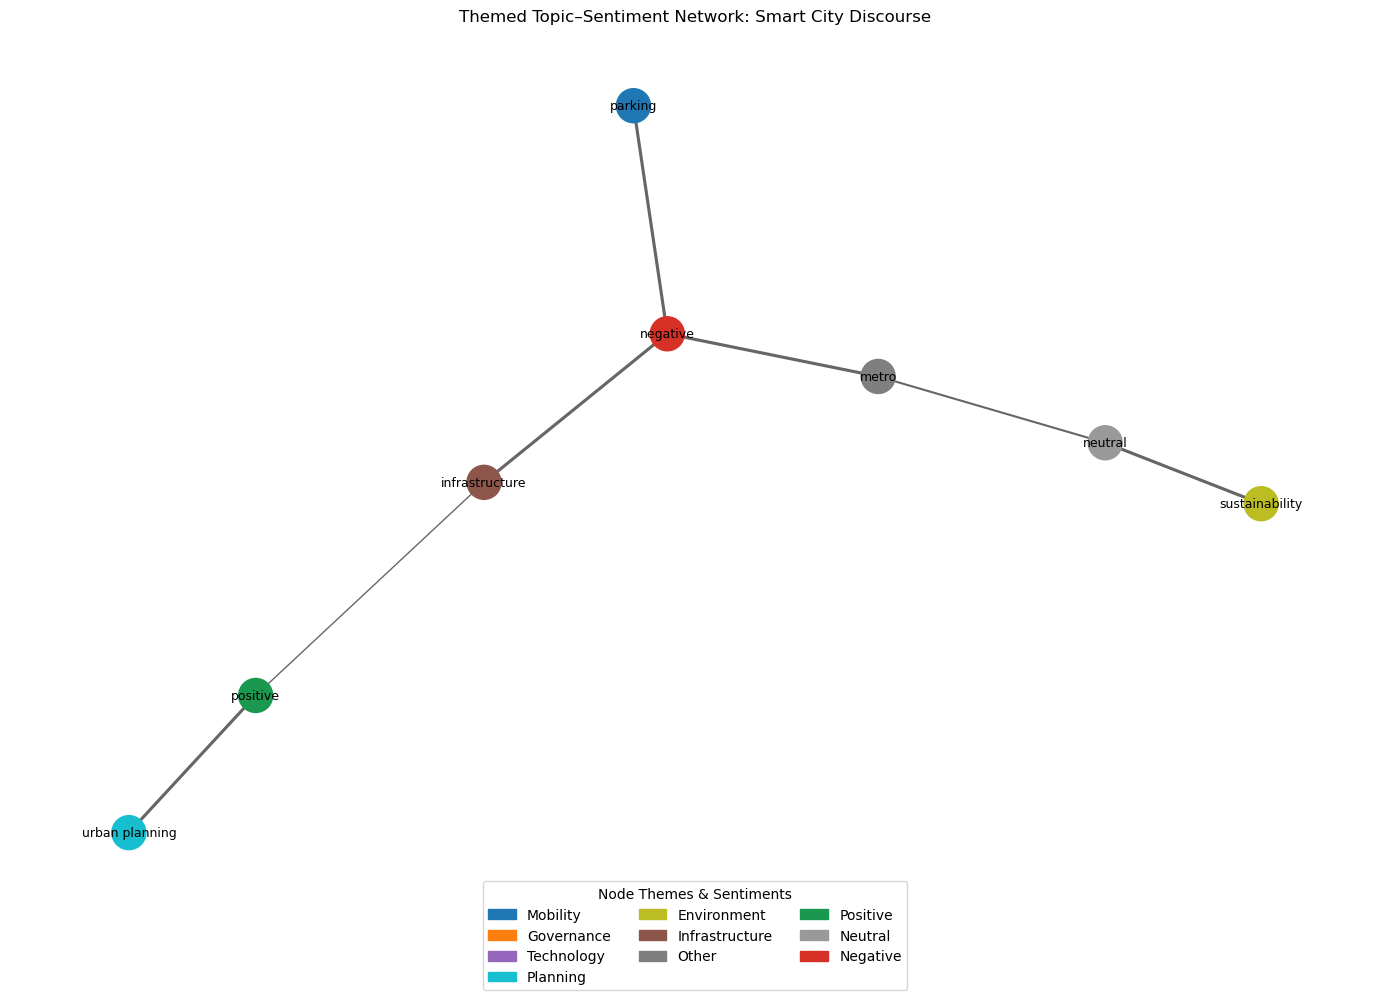

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.patches as mpatches

# Step 1: Clean and prepare data
df_filtered = df[df["Keyword"].notna() & (df["Keyword"] != "No Keyword Matched")].copy()

# Theme mapping
theme_map = {
    "bike": "Mobility", "transport": "Mobility", "parking": "Mobility",
    "surveillance": "Governance", "city council": "Governance", "e-government": "Governance",
    "wifi": "Technology", "apps": "Technology",
    "urban planning": "Planning",
    "sustainability": "Environment", "green city": "Environment",
    "infrastructure": "Infrastructure", "metro": "Other"
}
df_filtered["Theme"] = df_filtered["Keyword"].map(theme_map).fillna("Other")

# Count keyword–sentiment pairs
edge_data = df_filtered.groupby(["Keyword", "Sentiment"]).size().reset_index(name="count")

# Step 2: Create network
G = nx.Graph()

for _, row in edge_data.iterrows():
    keyword = row["Keyword"]
    sentiment = row["Sentiment"]
    weight = row["count"]
    theme = df_filtered[df_filtered["Keyword"] == keyword]["Theme"].iloc[0]

    G.add_node(keyword, type="keyword", theme=theme)
    G.add_node(sentiment, type="sentiment")
    G.add_edge(keyword, sentiment, weight=weight)

# Step 3: Define separate color sets

# Distinct theme colors
theme_colors = {
    "Mobility": "#1f77b4",        # Blue
    "Governance": "#ff7f0e",      # Orange
    "Technology": "#9467bd",      # Purple
    "Planning": "#17becf",        # Cyan
    "Environment": "#bcbd22",     # Olive
    "Infrastructure": "#8c564b",  # Brown
    "Other": "#7f7f7f"            # Gray
}

# Distinct sentiment colors
sentiment_colors = {
    "positive": "#1a9850",  # Dark green
    "neutral": "#999999",   # Mid gray
    "negative": "#d73027"   # Dark red
}

# Step 4: Assign node colors
node_colors = []
for node in G.nodes():
    if G.nodes[node].get("type") == "sentiment":
        node_colors.append(sentiment_colors.get(node, "#000000"))
    else:
        theme = G.nodes[node].get("theme", "Other")
        node_colors.append(theme_colors.get(theme, "#7f7f7f"))

# Step 5: Draw network
pos = nx.spring_layout(G, k=0.6, seed=42)
plt.figure(figsize=(14, 10))

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=600)
nx.draw_networkx_labels(G, pos, font_size=9)
nx.draw_networkx_edges(
    G, pos,
    width=[G[u][v]["weight"] / 4 for u, v in G.edges()],
    alpha=0.6
)

plt.title("Themed Topic–Sentiment Network: Smart City Discourse")
plt.axis('off')

# Step 6: Add legend (non-overlapping)
legend_handles = []

# Theme legends
for theme, color in theme_colors.items():
    legend_handles.append(mpatches.Patch(color=color, label=theme))

# Sentiment legends
for sentiment, color in sentiment_colors.items():
    legend_handles.append(mpatches.Patch(color=color, label=sentiment.capitalize()))

plt.legend(
    handles=legend_handles,
    title="Node Themes & Sentiments",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=3
)

# Save and show
plt.tight_layout()
plt.savefig("topic_sentiment_network_final.png", dpi=300, bbox_inches='tight')
plt.show()


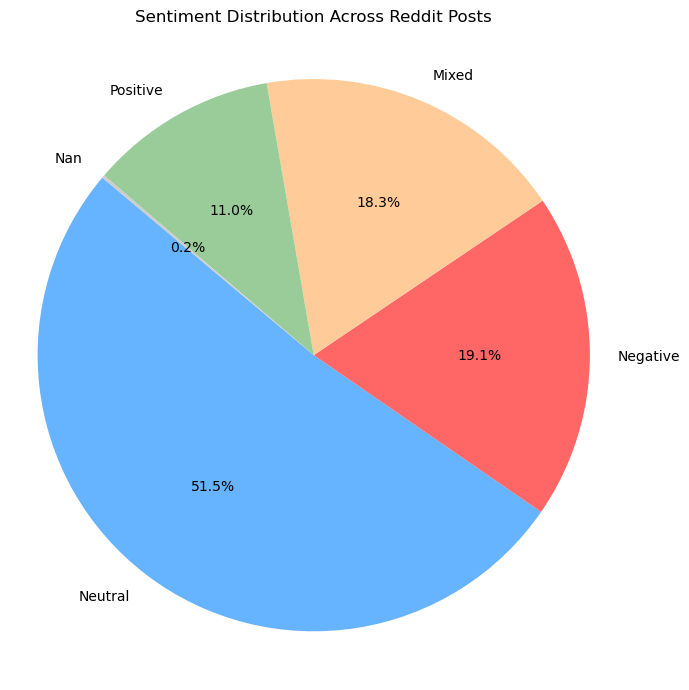

In [69]:
import matplotlib.pyplot as plt

# Sentiment counts (from your summary)
sentiment_counts = {
    "neutral": 600,
    "negative": 222,
    "mixed": 213,
    "positive": 128,
    "NaN": 2
}

# Extract labels and values
labels = [k.capitalize() for k in sentiment_counts.keys()]
sizes = list(sentiment_counts.values())

# Define custom colors
colors = ['#66b3ff', '#ff6666', '#ffcc99', '#99cc99', '#cccccc']

# Create the pie chart
plt.figure(figsize=(7, 7))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    colors=colors,
    startangle=140
)

plt.title("Sentiment Distribution Across Reddit Posts")
plt.axis('equal')  # Equal aspect ratio makes the pie chart circular
plt.tight_layout()
plt.savefig("sentiment_distribution_pie.png", dpi=300)
plt.show()
